In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import random

In [2]:
!pip install torchsummary

In [3]:
from torchsummary import summary

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Dataset

In [5]:
class WasteDataset(Dataset):
    def __init__(self, root_dir, split, random_seed, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.image_paths = []
        self.labels = []
        
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for subfolder in ['default', 'real_world']:
                subfolder_dir = os.path.join(class_dir, subfolder)
                image_names = os.listdir(subfolder_dir)
                random.seed(random_seed)
                random.shuffle(image_names)
                
                if split == 'train':
                    image_names = image_names[:int(0.7 * len(image_names))]
                elif split == 'val':
                    image_names = image_names[int(0.7 * len(image_names)):int(0.9 * len(image_names))]
                elif split == 'test':
                    image_names = image_names[int(0.9 * len(image_names)):]
                
                for image_name in image_names:
                    self.image_paths.append(os.path.join(subfolder_dir, image_name))
                    self.labels.append(i)
                    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, ndx):
        image_path = self.image_paths[ndx]
        label = self.labels[ndx]
        image = Image.open(image_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

### Model

In [6]:
class WastClassify_CNN(nn.Module):
    def __init__(self, num_classes=30):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
    
    def forward(self, x):
        out = torch.relu(self.conv1(x))
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        out = torch.relu(self.conv2(out))
        out = F.max_pool2d(out, kernel_size=2, stride=2)
        out = out.view(-1, 64 * 56 * 56)
        #out = out.view(out.size(0), -1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [7]:
dataset_path = '/kaggle/input/recyclable-and-household-waste-classification/images/images'
batch_size = 32
num_epochs = 5
learning_rate = 0.001

In [8]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
train_dataset = WasteDataset(dataset_path, split='train', transform=transform, random_seed=42)
val_dataset = WasteDataset(dataset_path, split='val', transform=transform, random_seed=42)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform, random_seed=42)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
num_classes = len(train_dataset.classes)
model = WastClassify_CNN(num_classes)
model = torch.nn.DataParallel(model, device_ids=[0, 1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
            Conv2d-2         [-1, 32, 224, 224]             896
            Conv2d-3         [-1, 64, 112, 112]          18,496
            Conv2d-4         [-1, 64, 112, 112]          18,496
            Linear-5                  [-1, 512]     102,760,960
            Linear-6                  [-1, 512]     102,760,960
            Linear-7                   [-1, 30]          15,390
  WastClassify_CNN-8                   [-1, 30]               0
            Linear-9                   [-1, 30]          15,390
 WastClassify_CNN-10                   [-1, 30]               0
Total params: 205,591,484
Trainable params: 205,591,484
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 36.76
Params size (MB): 784.27


### Training Loop

In [15]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
print("Start Training!")
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")
        

Start Training!
Epoch [1/5], Train Loss: 3.0650, Val Loss: 2.5112
Epoch [2/5], Train Loss: 1.7162, Val Loss: 1.9072
Epoch [3/5], Train Loss: 0.5564, Val Loss: 2.1190
Epoch [4/5], Train Loss: 0.2452, Val Loss: 2.2983
Epoch [5/5], Train Loss: 0.1487, Val Loss: 2.3650
Training completed!


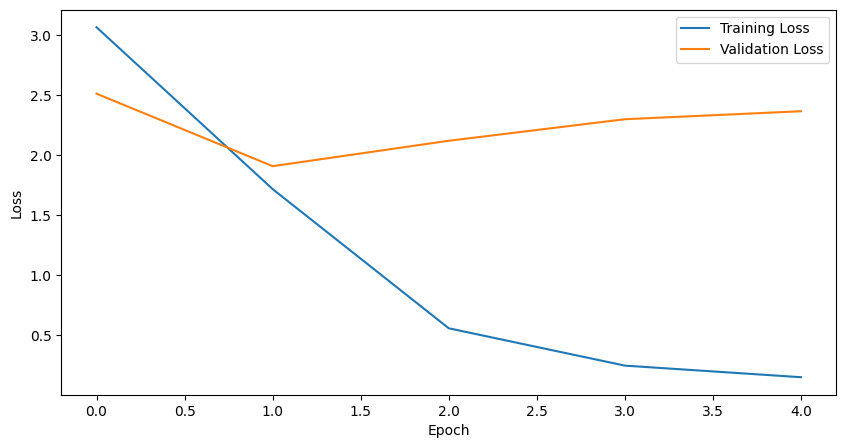

In [16]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

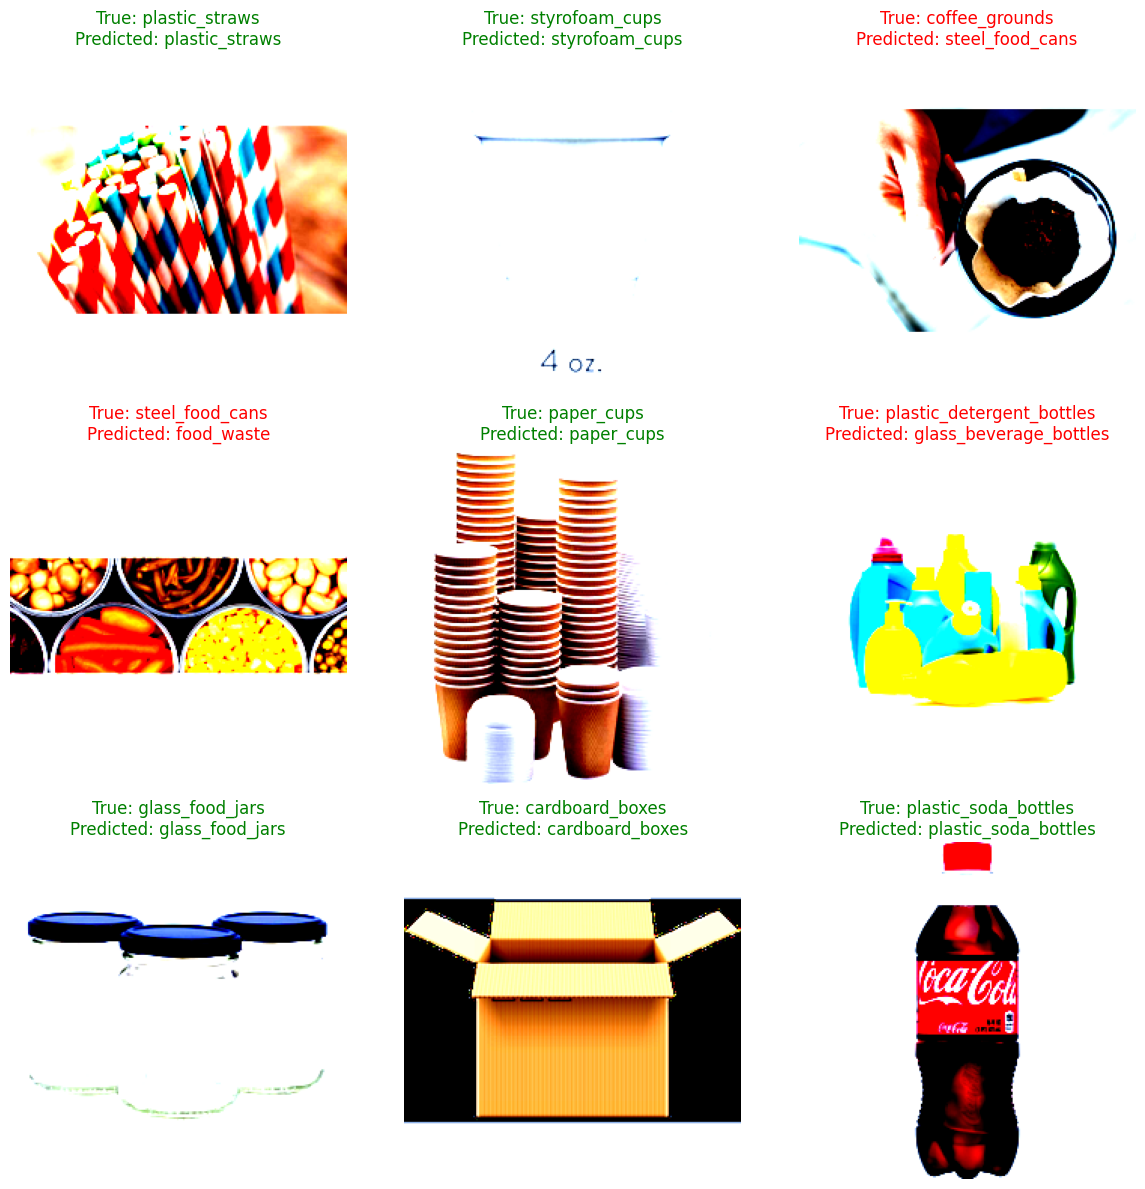

In [21]:
# Perform sample inferences on random test images with different labels
model.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    selected_images = []
    selected_labels = []
    selected_predicted = []
    
    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')
        
        output = model(image)
        _, predicted = torch.max(output, 1)
        
        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())
        
        if len(selected_labels) == 9:
            break
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        true_label = train_dataset.classes[selected_labels[i]]
        pred_label = train_dataset.classes[selected_predicted[i]]
        title = f"True: {true_label}\nPredicted: {pred_label}"
        t_color = 'green' if selected_labels[i] == selected_predicted[i] else 'red'
        axes[i].set_title(title, color=t_color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [29]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

In [23]:
train_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_rn50 = transforms.Compose([
    transforms.Resize(size=232, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=224),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
train_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    transforms.RandomRotation(45), # augmentation: random rotation 45 degree
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_ev2 = transforms.Compose([
    transforms.Resize(size=384, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop(size=384),
    # do not augment in validation data
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [42]:
train_dataset = WasteDataset(dataset_path, split='train', transform=train_transform_rn50, random_seed=42)
val_dataset = WasteDataset(dataset_path, split='val', transform=val_transform_rn50, random_seed=42)
test_dataset = WasteDataset(dataset_path, split='test', transform=transform, random_seed=42)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [28]:
print(f"Number of Train Dataloader: {len(train_dataloader)} batches")

Number of Train Dataloader: 329 batches


### Load pre-trained ResNet50 model: ResNet50_Weights.IMAGENET1K_V2

In [45]:
model_rn50 = resnet50(weights=ResNet50_Weights.DEFAULT)

model_rn50.fc = nn.Sequential(nn.Linear(in_features=model_rn50.fc.in_features, out_features=len(train_dataset.classes)))

for param in model_rn50.parameters():
    param.requires_grad = False

for param in model_rn50.fc.parameters():
    param.requires_grad = True

model_rn50 = torch.nn.DataParallel(model_rn50, device_ids=[0, 1]).to(device)
#model_rn50.to(device)

In [46]:
summary(model_rn50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
              ReLU-4         [-1, 64, 112, 112]               0
         MaxPool2d-5           [-1, 64, 56, 56]               0
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
            Conv2d-8           [-1, 64, 56, 56]           4,096
         MaxPool2d-9           [-1, 64, 56, 56]               0
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]           4,096
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [47]:
loss_fn = nn.CrossEntropyLoss()
optim_rn50 = optim.Adam(params=model_rn50.parameters(), lr=0.001)

In [49]:
# Lists to store the training and validation losses
train_losses = []
val_losses = []

# Training loop
print("Start ResNet50 Training!")
for epoch in range(num_epochs):
    # Training
    model_rn50.train()
    train_loss = 0.0
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        output = model_rn50(images)
        loss = loss_fn(output, labels)
        
        optim_rn50.zero_grad()
        loss.backward()
        optim_rn50.step()
        
        train_loss += loss.item() * images.size(0)
    
    train_loss /= len(train_dataset)
    train_losses.append(train_loss)
    
    # Validation
    model_rn50.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            output = model_rn50(images)
            loss = loss_fn(output, labels)

            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_dataset)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

print("Training completed!")

Start ResNet50 Training!
Epoch [1/5], Train Loss: 1.1894, Val Loss: 0.9468
Epoch [2/5], Train Loss: 0.9375, Val Loss: 0.8151
Epoch [3/5], Train Loss: 0.8189, Val Loss: 0.7297
Epoch [4/5], Train Loss: 0.7420, Val Loss: 0.7172
Epoch [5/5], Train Loss: 0.6787, Val Loss: 0.6765
Training completed!


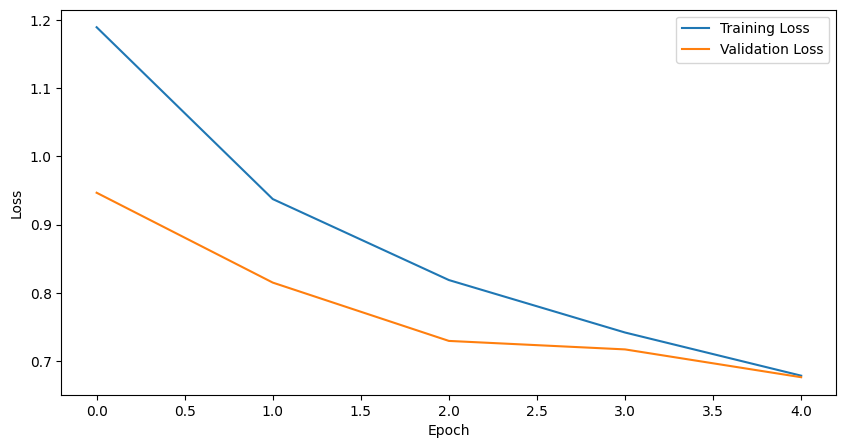

In [50]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

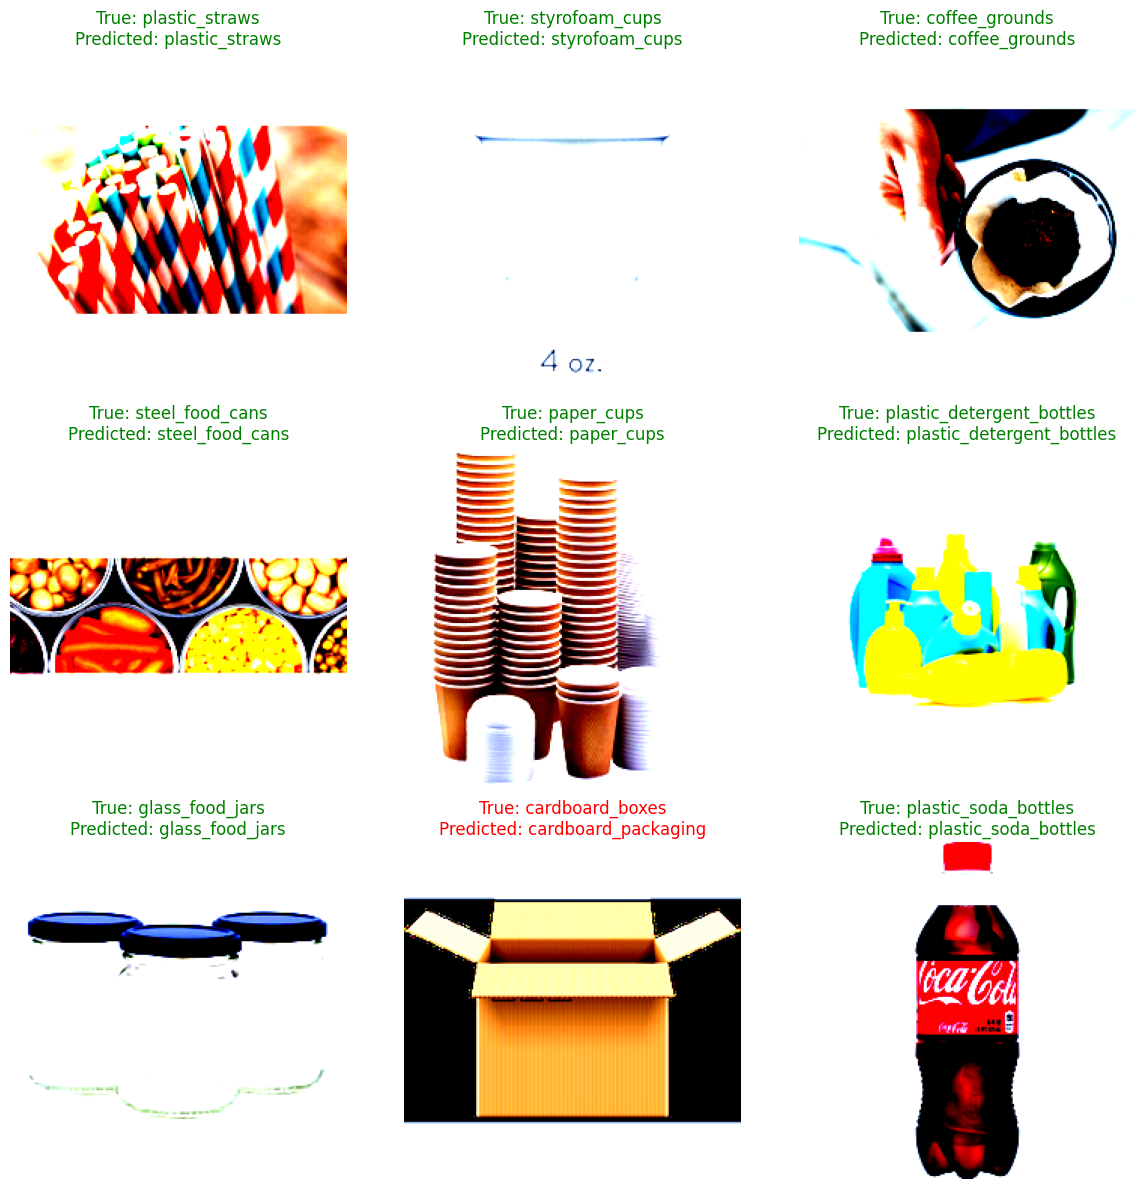

In [54]:
# Perform sample inferences on random test images with different labels
model_rn50.eval()
with torch.no_grad():
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    selected_images = []
    selected_labels = []
    selected_predicted = []
    
    for index in indices:
        image, label = test_dataset[index]
        image = image.unsqueeze(0).to('cuda')
        
        output = model_rn50(image)
        _, predicted = torch.max(output, 1)
        
        if label not in selected_labels:
            selected_images.append(image)
            selected_labels.append(label)
            selected_predicted.append(predicted.item())
        
        if len(selected_labels) == 9:
            break
    
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    axes = axes.flatten()
    
    for i in range(9):
        axes[i].imshow(selected_images[i].squeeze().cpu().permute(1, 2, 0))
        true_label = train_dataset.classes[selected_labels[i]]
        pred_label = train_dataset.classes[selected_predicted[i]]
        title = f"True: {true_label}\nPredicted: {pred_label}"
        t_color = 'green' if selected_labels[i] == selected_predicted[i] else 'red'
        axes[i].set_title(title, color=t_color)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()